# classification : 分類問題

# Preparation

## Preparation of google drive (if required)

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch220118/MiniCTorch_Prototype/notebook"

import sys
sys.path.append("../")

/content/drive/My Drive/Colab Notebooks/ctorch220118/MiniCTorch_Prototype/notebook


## Installation of MiniCTorch

In [4]:
! pip install lark-parser

     |████████████████████████████████| 103 kB 5.3 MB/s 


In [ ]:
! pip install git+https://github.com/kojima-r/MiniCTorch_Prototype.git

# Target Python Program

In [5]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler

## データ読み込み

In [7]:
# データ読み込み
iris = datasets.load_iris()
data   = iris['data']
target = iris['target']

# 学習データと検証データに分割
x_train, x_valid, y_train, y_valid = train_test_split( data, target, shuffle=True )

# 特徴量の標準化
scaler = StandardScaler()
scaler.fit( x_train )

x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)

# Tensor型に変換
# 学習に入れるときはfloat型 or long型になっている必要があるのここで変換してしまう
x  = torch.from_numpy(x_train).float()
y  = torch.from_numpy(y_train).long()
vx = torch.from_numpy(x_valid).float()
vy = torch.from_numpy(y_valid).long()

print('x_train : ', x_train.shape)
print('y_train : ', y_train.shape)
print('x_valid : ', x_valid.shape)
print('y_valid : ', y_valid.shape)

x_train :  (112, 4)
y_train :  (112,)
x_valid :  (38, 4)
y_valid :  (38,)


## ニューラルネットワークの定義

In [8]:
class Model(torch.nn.Module):

  class Net( torch.nn.Module ):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 64)
        #self.drop1 = nn.Dropout(0.5) ### drop
        self.fc2 = nn.Linear(64, 3)
    
    def forward(self, x):
        self.x1 = F.relu(self.fc1(x))
        #self.x2 = self.drop1(self.x1)  ## drop
        #x = self.fc2(self.x2)
        x = self.fc2(self.x1)
        return x

  class Loss( torch.nn.Module ):
    def __init__( self ):
      super().__init__()
      print("create loss class")

    def forward(self,y,t):
      loss = nn.CrossEntropyLoss()
      #loss = nn.NLLLoss()
      output = loss( y, t )
      return output

  def __init__( self, t ):
    super( Model, self ).__init__()
    print("create model class")
    self.net  = self.Net()
    self.loss = self.Loss()
    self.target = t

  def forward( self, x ):
    self.out = self.net( x )
    out = self.loss( self.out, self.target )
    return out

## プロジェクト名、作業フォルダ、JSONファイル名の設定

In [9]:
project = 'clas'
folder = './classification'
json_path = folder + '/' + project +'.json'

In [10]:
! mkdir -p classification

## 計算グラフをJSONファイルに出力する

In [11]:
def generate_json( json_path, input, target ):
    model = Model( target )
    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        minictorch.trace( model, input, json_path )
    return model

In [12]:
torch.manual_seed( 1 )

batch_size = 16
print(x.shape)
print(y.shape)
inputs = x[0:batch_size,:]
labels = y[0:batch_size]
inputs.requires_grad = True

model = generate_json( json_path, inputs, labels )

torch.Size([112, 4])
torch.Size([112])
create model class
create loss class
[SAVE] ./classification/clas.json
skip: Model/Net[net]/Linear[fc1]/weight/fc1
skip: Model/Net[net]/Linear[fc1]/weight/fc1
skip: Model/Net[net]/Linear[fc2]/weight/fc2
skip: Model/Net[net]/Linear[fc2]/weight/fc2


一回の順伝播、逆伝播のC++コードを生成する

In [13]:
minictorch.convert_all( project, folder, model, json_path, inputs, {"input_data":x_train, "target_data":y_train}, sol="classification", batch=batch_size, shuffle=1 )

[JSON] ./classification/clas.json
{'name': 'Model/Net[net]/Linear[fc1]/weight/weight.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'Model/Net[net]/Linear[fc1]/bias/bias.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'Model/Net[net]/Linear[fc2]/weight/weight', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
{'name': 'Model/Net[net]/Linear[fc2]/bias/bias', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
{'name': 'Model/Loss[loss]/60', 'op': 'prim::Constant', 'in': [], 'output_id': 0, 'shape': [16], 'constant_value': [0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 2.0], 'out': [13], 'sorted_id': 8}
[PARAM] ./classification/clas_param.cpp
{'name': 'input/x', 'op': 'IO Node', 'in': [], 'output_id': 0, 'shape': [16, 4], 'out': [3], 'sorted_id': 0}
{'name': 'Model/Net[net

In [14]:
#check code
with torch.set_grad_enabled(True):
  output = model( inputs )
  print("output",output)

  model.zero_grad()
  output.backward()
  print("output grad",output.grad)
  print("input grad",inputs.grad)

  # ラベルを予測
  preds = torch.argmax( model.out, dim=1 )

  # イテレーション結果の計算
  epoch_loss = output * inputs.size(0)

  # 正解数の合計を更新
  epoch_corrects = torch.sum( preds == labels.data )

  epoch_loss = epoch_loss / float(inputs.size(0))
  epoch_acc  = epoch_corrects.double() / float(inputs.size(0))

  epoch=1
  print('Train Loss {}: {:.4f} Acc: {:.4f}'.format( epoch, epoch_loss, epoch_acc ))

output tensor(1.1509, grad_fn=<NllLossBackward0>)
output grad None
input grad tensor([[-1.3524e-02, -3.9302e-03,  2.1217e-03, -2.2796e-03],
        [-7.5768e-03, -1.5715e-03, -1.2155e-03,  4.5842e-05],
        [-1.0588e-02, -1.2415e-03,  1.3152e-04, -1.1135e-03],
        [ 6.9689e-03,  8.0385e-03, -6.8113e-03,  5.5030e-03],
        [ 5.7107e-03, -8.6317e-03,  5.8216e-03, -4.4492e-03],
        [ 9.7851e-03,  5.7547e-03, -5.4056e-03,  4.3847e-03],
        [-4.0325e-03, -1.2181e-03, -4.4736e-03, -8.6903e-03],
        [-2.4874e-03, -8.3324e-04,  3.9762e-04, -1.0486e-02],
        [-1.0818e-02, -2.2349e-03,  3.5609e-03,  3.2196e-04],
        [ 1.0223e-02, -2.2210e-03,  9.5113e-03,  3.5008e-03],
        [-1.0879e-02,  1.9774e-03,  1.8270e-03,  3.0248e-03],
        [ 6.7500e-04, -4.6420e-03, -1.6586e-03, -1.0995e-02],
        [ 3.1268e-03,  7.5256e-03, -6.5283e-04,  4.3652e-03],
        [ 1.5261e-03,  7.0888e-03,  3.7737e-05,  4.7059e-03],
        [-9.6446e-03, -4.1623e-03,  2.3427e-03, -2.234

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


# C++予測コード

## 環境構築
(注意) インストール済みの場合は各自の環境に合わせて変更して下さい。

In [ ]:
! git clone https://github.com/xtensor-stack/xtensor.git
! git clone https://github.com/xtensor-stack/xtensor-blas.git
! git clone https://github.com/xtensor-stack/xtl.git
! git clone https://github.com/nlohmann/json.git

Cloning into 'xtensor'...
remote: Enumerating objects: 20418, done.
remote: Counting objects: 100% (3167/3167), done.
remote: Compressing objects: 100% (515/515), done.
remote: Total 20418 (delta 2722), reused 2919 (delta 2637), pack-reused 17251
Receiving objects: 100% (20418/20418), 10.07 MiB | 3.66 MiB/s, done.
Resolving deltas: 100% (14570/14570), done.
Checking out files: 100% (385/385), done.
Cloning into 'xtensor-blas'...
remote: Enumerating objects: 3857, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 3857 (delta 83), reused 96 (delta 41), pack-reused 3688
Receiving objects: 100% (3857/3857), 4.13 MiB | 6.04 MiB/s, done.
Resolving deltas: 100% (3155/3155), done.
Checking out files: 100% (1435/1435), done.
Cloning into 'xtl'...
remote: Enumerating objects: 2399, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 2399 (delta 125), reused 137 

In [ ]:
! git clone https://github.com/kojima-r/MiniCTorch_Prototype.git

Cloning into 'MiniCTorch_Prototype'...
remote: Enumerating objects: 728, done.
remote: Counting objects: 100% (728/728), done.
remote: Compressing objects: 100% (359/359), done.
remote: Total 728 (delta 499), reused 583 (delta 367), pack-reused 0
Receiving objects: 100% (728/728), 42.78 MiB | 10.74 MiB/s, done.
Resolving deltas: 100% (499/499), done.


# コンパイル

In [15]:
C_SRC = './classification/clas.cpp ./classification/clas_param.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include'
C_OUT = './classification/clas'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC $C_OPT -lcblas -o $C_OUT

SRC = ./classification/clas.cpp ./classification/clas_param.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./classification/clas


In [16]:
!./classification/clas

### forward computation ...
 1.150947
### backward computation ...
input_grad{{-0.013524, -0.00393 ,  0.002122, -0.00228 },
 {-0.007577, -0.001571, -0.001215,  0.000046},
 {-0.010588, -0.001242,  0.000132, -0.001114},
 { 0.006969,  0.008038, -0.006811,  0.005503},
 { 0.005711, -0.008632,  0.005822, -0.004449},
 { 0.009785,  0.005755, -0.005406,  0.004385},
 {-0.004033, -0.001218, -0.004474, -0.00869 },
 {-0.002487, -0.000833,  0.000398, -0.010486},
 {-0.010818, -0.002235,  0.003561,  0.000322},
 { 0.010223, -0.002221,  0.009511,  0.003501},
 {-0.010879,  0.001977,  0.001827,  0.003025},
 { 0.000675, -0.004642, -0.001659, -0.010995},
 { 0.003127,  0.007526, -0.000653,  0.004365},
 { 0.001526,  0.007089,  0.000038,  0.004706},
 {-0.009645, -0.004162,  0.002343, -0.002235},
 { 0.005268,  0.008545, -0.004862,  0.005726}}


# Python 学習コード

In [ ]:
torch.manual_seed( 1 )

#inputs.requires_grad = True
model = Model( labels )

lr = 0.01
opt = torch.optim.SGD( model.parameters(), lr)

epochs = 200
batch_size = 16

num_train = len(x_train)
n_batch = num_train // batch_size  # 1エポックあたりのバッチ数
print("batch",n_batch,len(x_train),batch_size)

epoch_loss = []
epoch_acc = []
for epoch in range(epochs):
    
    # -- 学習 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # インデックスをシャッフルする

    model.train()   # モデルを訓練モードに設定

    total_loss = 0.0
    total_corrects = 0
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[ j*batch_size : (j+1)*batch_size ]
        inputs = x[mb_index, :]
        labels = y[mb_index]
       
        # 順伝播と逆伝播
        model.target = labels
        loss = model( inputs )
        total_loss += loss;

        # 正解数の合計を更新
        #_, preds = torch.max( model.out, 1 )
        preds = torch.argmax( model.out, dim=1 )
        num = torch.sum( preds == labels )
        total_corrects += num

        opt.zero_grad()
        loss.backward()
        opt.step()

    total_acc  = total_corrects.double() / float(num_train)
    print('Train Loss {}: {:.4f} Acc: {:.4f} {}'.format( epoch, total_loss, total_acc, total_corrects ))

    epoch_loss.append( total_loss )
    epoch_acc.append( total_acc )

create model class
create loss class
batch 7 112 16
Train Loss 0: 7.5884 Acc: 0.1964 22
Train Loss 1: 6.6343 Acc: 0.4732 53
Train Loss 2: 5.9222 Acc: 0.6786 76
Train Loss 3: 5.3966 Acc: 0.7054 79
Train Loss 4: 4.9902 Acc: 0.7143 80
Train Loss 5: 4.6673 Acc: 0.7321 82
Train Loss 6: 4.4155 Acc: 0.7589 85
Train Loss 7: 4.1993 Acc: 0.7589 85
Train Loss 8: 4.0208 Acc: 0.7768 87
Train Loss 9: 3.8601 Acc: 0.8036 90
Train Loss 10: 3.7246 Acc: 0.8125 91
Train Loss 11: 3.6014 Acc: 0.8482 95
Train Loss 12: 3.4913 Acc: 0.8482 95
Train Loss 13: 3.3893 Acc: 0.8661 97
Train Loss 14: 3.2945 Acc: 0.8750 98
Train Loss 15: 3.2132 Acc: 0.8750 98
Train Loss 16: 3.1343 Acc: 0.8750 98
Train Loss 17: 3.0604 Acc: 0.8750 98
Train Loss 18: 2.9898 Acc: 0.8750 98
Train Loss 19: 2.9275 Acc: 0.8750 98
Train Loss 20: 2.8659 Acc: 0.8839 99
Train Loss 21: 2.8138 Acc: 0.8839 99
Train Loss 22: 2.7572 Acc: 0.8929 100
Train Loss 23: 2.7120 Acc: 0.9018 101
Train Loss 24: 2.6585 Acc: 0.9018 101
Train Loss 25: 2.6145 Acc: 0.9

収束状況グラフを描画する

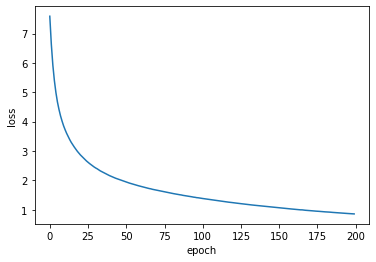

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

正解率を描画する

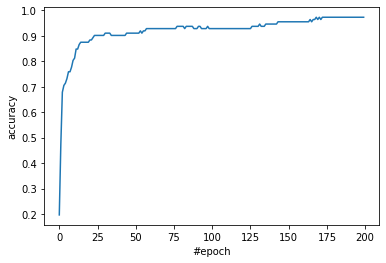

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_acc))),epoch_acc )
ax.set_xlabel('#epoch')
ax.set_ylabel('accuracy')
fig.show()

# C++ 学習コード

学習用C++コードをコンパイル、リンクする

In [17]:
C_SRC = './classification/clas_train.cpp ./classification/clas_param.cpp ./classification/clas.cpp ./classification/clas_data.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include '
C_OUT = './classification/clas_train'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC -D_TRAIN $C_OPT -lcblas -o $C_OUT

SRC = ./classification/clas_train.cpp ./classification/clas_param.cpp ./classification/clas.cpp ./classification/clas_data.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./classification/clas_train


In [18]:
! ./classification/clas_train

epoch_num : 200
batch  number  : 7,16
learning ratio : 0.01
total_loss : epoch 0 : loss 7.55366 : Acc 0.160714 18
total_loss : epoch 0 : loss 0.994669 : Acc 0.276786 31
total_loss : epoch 1 : loss 6.62477 : Acc 0.446429 50
total_loss : epoch 1 : loss 0.884578 : Acc 0.651786 73
total_loss : epoch 2 : loss 5.93978 : Acc 0.678571 76
total_loss : epoch 2 : loss 0.802776 : Acc 0.705357 79
total_loss : epoch 3 : loss 5.43021 : Acc 0.714286 80
total_loss : epoch 3 : loss 0.740738 : Acc 0.714286 80
total_loss : epoch 4 : loss 5.04737 : Acc 0.714286 80
total_loss : epoch 4 : loss 0.692529 : Acc 0.732143 82
total_loss : epoch 5 : loss 4.73319 : Acc 0.732143 82
total_loss : epoch 5 : loss 0.653832 : Acc 0.741071 83
total_loss : epoch 6 : loss 4.48357 : Acc 0.75 84
total_loss : epoch 6 : loss 0.622042 : Acc 0.75 84
total_loss : epoch 7 : loss 4.28035 : Acc 0.758929 85
total_loss : epoch 7 : loss 0.595162 : Acc 0.776786 87
total_loss : epoch 8 : loss 4.10108 : Acc 0.776786 87
total_loss : epoch 8 :

In [19]:
# read output file from c++ code
path = folder + '/' + project + '.out'
f = open( path, 'r')

loss = []
acc=[]

datalist = f.readlines()
for data in datalist:
  #print(data)
  ds = data.split(',')
  loss.append( float(ds[0]) )
  acc.append( float(ds[1]) )

f.close()

print("[OUT]",path)
print("epoch =", len(loss))
print( loss )
print(acc)

[OUT] ./classification/clas.out
epoch = 200
[0.994669, 0.884578, 0.802776, 0.740738, 0.692529, 0.653832, 0.622042, 0.595162, 0.571989, 0.551821, 0.533827, 0.517696, 0.503059, 0.489731, 0.477499, 0.466186, 0.455735, 0.445994, 0.436903, 0.4284, 0.420425, 0.412927, 0.405862, 0.399205, 0.392907, 0.38693, 0.381275, 0.375908, 0.3708, 0.365921, 0.361268, 0.356827, 0.352576, 0.348502, 0.344591, 0.340845, 0.337234, 0.333772, 0.330436, 0.327222, 0.324111, 0.321109, 0.318203, 0.315393, 0.312673, 0.310037, 0.307476, 0.304995, 0.302584, 0.300242, 0.297962, 0.29574, 0.293583, 0.291474, 0.289417, 0.287404, 0.285439, 0.28352, 0.281639, 0.2798, 0.277994, 0.276222, 0.274487, 0.272785, 0.271118, 0.269482, 0.267875, 0.266295, 0.264741, 0.263194, 0.261671, 0.260174, 0.258689, 0.257227, 0.255786, 0.254367, 0.252963, 0.251577, 0.250207, 0.248855, 0.24752, 0.246202, 0.244896, 0.243606, 0.242332, 0.241075, 0.239835, 0.238609, 0.237395, 0.236198, 0.235012, 0.233834, 0.23266, 0.231503, 0.230357, 0.229224, 0.2281

収束状況グラフを描画する

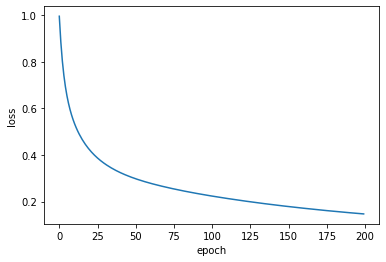

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(loss))), loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

正解率を描画する

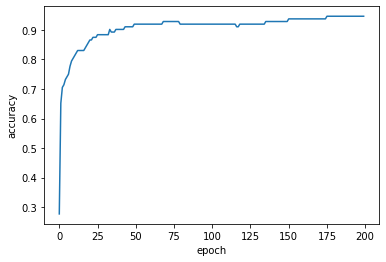

In [21]:
# 正解率
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(acc))), acc)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
fig.show()